# Using Image Detection Models
This notebook demonstrates a standardized pipeline for utilizing pre-trained models (SSD) and their associated weights from the Torch Hub.

SSD300 is a pre-trained model available in PyTorch's Torchvision module. It is a Single Shot Detector model, which means it uses a single deep neural network to detect objects in images.

## What is Object Detection

Object detection is a computer vision technology that identifies and locates objects in digital images and videos .

![image.png](https://i.ibb.co/F4BHGx2/workshop3-2-what-is-od.png)

## What is Pre-trained model?
A pre-trained model is a machine learning model that has already been trained on a large dataset, typically for a specific task, and has learned to recognize patterns and relationships within that data.

In the case of SSD300, it has been pre-trained on a large dataset of images for certain objects classes (COCO - Common Objects in Context). to detect objects within those images. This pre-training process involves:

1. Training the model on a large dataset with labeled objects (e.g., bounding boxes around objects)
2. Optimizing the model's parameters to minimize the error between predicted and actual object locations
3. Saving the trained model weights and architecture onto pytorch hub

By utilizing pre-trained models like SSD300, you can:
- **Build upon existing knowledge**: Leverage the model's learned patterns and relationships.
- **Fine-tune for your task**: Adapt the model to your specific object detection needs with a smaller dataset.
- **Efficient learning**: Save time and resources by not starting from scratch.

Pre-trained models like SSD300 are useful because they:
- Save time and resources by not requiring training from scratch
- Provide a solid starting point for your specific task
- Can be fine-tuned for your specific needs


## Resources

The PyTorch vision library provides a comprehensive selection of pre-trained object detection models

- [Torch Vision Model](https://pytorch.org/vision/stable/models.html) : List of available models and weights.
- [Torch Official Tutorial](https://pytorch.org/hub/pytorch_vision_resnet/) : Tutorial on basic pytorch.
- [Torch SSD_VGG](https://pytorch.org/vision/main/models/ssd.html): Pytoch module on SSD_VGG
- [Nvidia Hub implementation](https://pytorch.org/hub/nvidia_deeplearningexamples_ssd/) : nvidia's hosted ssd on pytorch hub, with resnet-50 instead of vgg model as backbone.
- [COCO datasets](https://cocodataset.org/#explore)

# Libraries

In [2]:
%mkdir imgs

mkdir: cannot create directory ‘imgs’: File exists


In [1]:
%%capture
# for google Colab, to setup the environment
%pip install torchinfo

In [2]:
import torch
import torchvision
from torchvision.transforms import functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from torchinfo import summary
import urllib

/Users/e-rongyong/brainhack-til/til-24-curriculum/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Model Loading - SSD300
The loaded model utilizes a pre-trained Single-Shot MultiBox Detector (SSD300) architecture built upon a VGG16 convolutional neural network (CNN).

In [3]:
from torchinfo import summary
import torchvision

# Load the pre-trained SSD300 VGG16 model
weights = torchvision.models.detection.SSD300_VGG16_Weights.DEFAULT
ssd_model = torchvision.models.detection.ssd300_vgg16(
    weights=True, box_score_thresh=0.9
)
ssd_model.eval()  # Set the model to evaluation mode
summary(ssd_model)

/Users/e-rongyong/brainhack-til/til-24-curriculum/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSD300_VGG16_Weights.COCO_V1`. You can also use `weights=SSD300_VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /Users/e-rongyong/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth
100%|██████████| 136M/136M [01:37<00:00, 1.47MB/s] 


Layer (type:depth-idx)                   Param #
SSD                                      --
├─SSDFeatureExtractorVGG: 1-1            512
│    └─Sequential: 2-1                   --
│    │    └─Conv2d: 3-1                  (1,792)
│    │    └─ReLU: 3-2                    --
│    │    └─Conv2d: 3-3                  (36,928)
│    │    └─ReLU: 3-4                    --
│    │    └─MaxPool2d: 3-5               --
│    │    └─Conv2d: 3-6                  73,856
│    │    └─ReLU: 3-7                    --
│    │    └─Conv2d: 3-8                  147,584
│    │    └─ReLU: 3-9                    --
│    │    └─MaxPool2d: 3-10              --
│    │    └─Conv2d: 3-11                 295,168
│    │    └─ReLU: 3-12                   --
│    │    └─Conv2d: 3-13                 590,080
│    │    └─ReLU: 3-14                   --
│    │    └─Conv2d: 3-15                 590,080
│    │    └─ReLU: 3-16                   --
│    │    └─MaxPool2d: 3-17              --
│    │    └─Conv2d: 3-18           

## 2. Image loading with PIL Image

In [4]:
from PIL import Image
from urllib.request import urlretrieve
from os import remove

def load_image(path_or_url):
    """Loads an image from a given URL or path. If the input is a URL,
    it downloads the image and saves it as a temporary file. If the input is a path,
    it loads the image from the path. The image is then converted to RGB format and returned.
    """
    if path_or_url.startswith("http"):  # assume URL if starts with http
        urlretrieve(path_or_url, "imgs/tmp.jpg")
        img = Image.open("imgs/tmp.jpg").convert("RGB")
        remove("imgs/tmp.jpg")  # cleanup temporary file
    else:
        img = Image.open(path_or_url).convert("RGB")
    return img

In [5]:
image = load_image("https://i.ibb.co/Z6L3q4j/dog1.jpg")

## 3. Preprocess the image
Define a transformation pipeline (adjust based on model requirements). 
 - The pixels value are normalised here, with the mean and standard deviation values for the ImageNet dataset.
 - The transformed image is then batched into a unit of 1 (via unsqueeze)

In [6]:
from torchvision import transforms

## Preprocess the image
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
processed_image = transform(image).unsqueeze(0)
processed_image.shape

torch.Size([1, 3, 6306, 4204])

## 4. Model inference

In [7]:
# Label Encoding
id_2_label = {idx: x for idx, x in enumerate(weights.meta["categories"])}

In [8]:
# Run inference
with torch.no_grad():
    detections = ssd_model(processed_image)[0]

In [10]:
detections

{'boxes': tensor([[  42.7664, 2520.1206, 3812.7847, 6082.9321],
         [   0.0000, 2603.4924, 4073.9541, 5939.0015],
         [2436.6519,    0.0000, 2640.6125,  838.7405],
         [  18.9274, 2653.3613, 2052.7224, 4357.2612],
         [ 122.7601, 2252.8303, 4204.0000, 5874.8110],
         [   0.0000, 2603.4924, 4073.9541, 5939.0015],
         [2360.0442,  130.8089, 2725.7559, 1119.7179],
         [   0.0000, 2723.5930, 4020.0657, 5928.0122],
         [2107.5637, 3607.3572, 3297.2888, 4758.5127],
         [1087.7489,  377.9813, 1261.5703, 1168.1238],
         [1763.3420,  178.3374, 1945.9083, 1058.4432],
         [ 934.9108, 2782.0754, 1398.8386, 3448.3572],
         [2355.6348,  144.5443, 2502.3369,  741.9896],
         [2309.6052, 3665.5862, 2872.7053, 5044.6499],
         [3133.8616, 5316.6538, 3566.8511, 5520.7163],
         [1186.1688,  446.4408, 1375.9108, 1107.8146],
         [ 994.8441,  450.6267, 1153.5854, 1075.4799],
         [2196.3235,    0.0000, 2640.5730,  602.9103],
 

## 5. Extracting and Visualising the output
- Object detection models' result consists of a dictionary of boxes, labels and scores. 
- The respectives keys extracted into a seperate list, which are then plotted out.

dog 0.9901628494262695


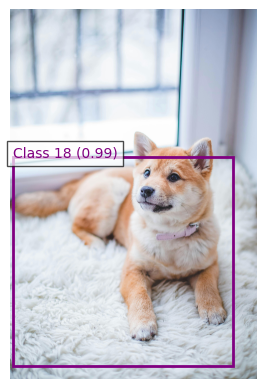

In [9]:
# Extract bounding boxes, labels, and scores
boxes = detections["boxes"]
labels = detections["labels"]
scores = detections["scores"]

# Visualize the results
class_colors = ["red", "blue", "green", "purple", "orange"]

plt.imshow(image)
for box, label, score in zip(boxes, labels, scores):
    if score > 0.1:
        class_id = label.item()  # Get the class ID
        class_color = class_colors[
            class_id % len(class_colors)
        ]  # Assign a color based on class ID
        print(id_2_label[label.item()], score.item())
        plt.gca().add_patch(
            plt.Rectangle(
                (box[0], box[1]),
                box[2] - box[0],
                box[3] - box[1],
                fill=False,
                edgecolor=class_color,
                linewidth=2,
            )
        )
        plt.text(
            box[0],
            box[1],
            f"Class {label.item()} ({score:.2f})",
            color=class_color,
            fontsize=10,
            bbox=dict(facecolor="white", alpha=0.7),
        )
plt.axis("off")
plt.show()

# Exercise (10 mins)
**1. Let's apply a pre-trained object detection model to predict objects in the image motocycle_with_cars. Note that this image has an RGBA channel, which needs to be converted to RGB using the .convert('RGB') method.**

The Image can be found in the imgs directory if you are had cloned the repo, or you can load through https://i.ibb.co/6YgXdfG/motocycle-with-cars.png

Here's how you can do it:
- Load the pre-trained model
- Load the image motocycle_with_cars
- Convert the image to RGB using .convert('RGB')
- Apply the pre-trained model to the image to predict objects

In [12]:
motorcycle_with_cars = load_image("https://i.ibb.co/6YgXdfG/motocycle-with-cars.png")

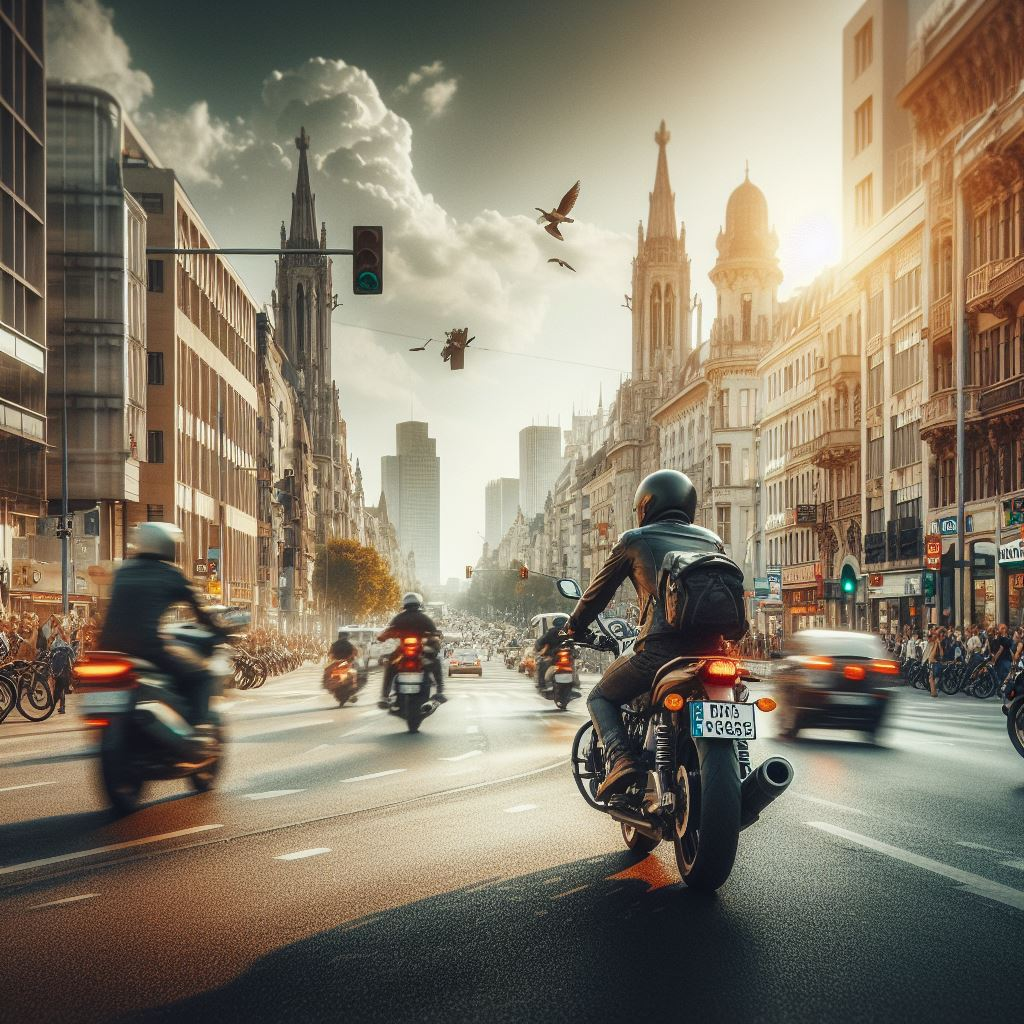

In [14]:
motorcycle_with_cars

In [15]:
processed_image = transform(motorcycle_with_cars).unsqueeze(0)

In [16]:
processed_image.shape

torch.Size([1, 3, 1024, 1024])

In [17]:
with torch.no_grad():
    detections = ssd_model(processed_image)[0]

motorcycle 0.9999300241470337
person 0.9990799427032471
motorcycle 0.9990511536598206
person 0.9960611462593079
car 0.9948698282241821
car 0.9764466285705566
motorcycle 0.8784974813461304
motorcycle 0.8465943336486816
person 0.7338146567344666
person 0.6924243569374084
motorcycle 0.6912610530853271
motorcycle 0.41802477836608887
traffic light 0.38825199007987976
person 0.37680792808532715
motorcycle 0.35299018025398254
person 0.2732304632663727
motorcycle 0.2600119709968567
motorcycle 0.2314571887254715
person 0.21842962503433228
person 0.20626021921634674
person 0.20195813477039337
person 0.17689485847949982
motorcycle 0.16851645708084106
airplane 0.16061042249202728
motorcycle 0.15153485536575317
motorcycle 0.14954878389835358
traffic light 0.1477227360010147
car 0.14634203910827637
bicycle 0.14577876031398773
traffic light 0.14521251618862152
car 0.13943712413311005
traffic light 0.13941137492656708
person 0.13816748559474945
motorcycle 0.13716717064380646
person 0.1345682442188263


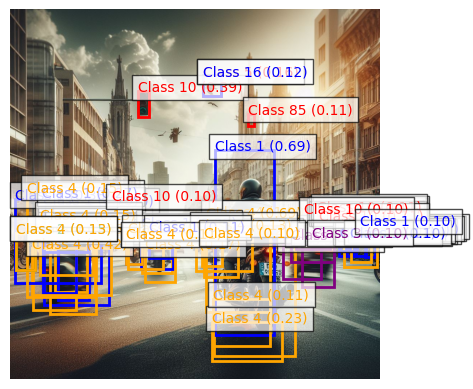

In [18]:
# Extract bounding boxes, labels, and scores
boxes = detections["boxes"]
labels = detections["labels"]
scores = detections["scores"]

# Visualize the results
class_colors = ["red", "blue", "green", "purple", "orange"]

plt.imshow(motorcycle_with_cars)
for box, label, score in zip(boxes, labels, scores):
    if score > 0.1:
        class_id = label.item()  # Get the class ID
        class_color = class_colors[
            class_id % len(class_colors)
        ]  # Assign a color based on class ID
        print(id_2_label[label.item()], score.item())
        plt.gca().add_patch(
            plt.Rectangle(
                (box[0], box[1]),
                box[2] - box[0],
                box[3] - box[1],
                fill=False,
                edgecolor=class_color,
                linewidth=2,
            )
        )
        plt.text(
            box[0],
            box[1],
            f"Class {label.item()} ({score:.2f})",
            color=class_color,
            fontsize=10,
            bbox=dict(facecolor="white", alpha=0.7),
        )
plt.axis("off")
plt.show()

## Bonus
**2. Predict the image with other Object detection models available on the torch hub.**

# Additional Notes
To Fine tune the model for specific object class the model is not trained for, we would have to fine-tune it for new annotated label.

Please refer to the chapter and notebooks on transfer learning (via fine tuning and feature extraction)